In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno  as msno
import datetime
from scipy.spatial.distance import cdist
import datetime

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

In [3]:
# read data & concatenate flight of 2 consecutive years -> 2007 & 2008
df = pd.concat([pd.read_csv('2003.csv'),pd.read_csv('2004.csv')], ignore_index=True)
# show header
df.head()
# show total number of samples and drop duplicates
totalsamples = df.shape[0]
print(totalsamples)

# drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
print(f'decrement: {(df.shape[0]/totalsamples)*100:.2f}%')

# remove rows where flight was cancelled as we are only inspecting delayed flights, Cancelled=1
df.drop(df[df['Cancelled'] == 1].index, inplace = True)
df.drop(df[df['Diverted'] == 1].index, inplace = True)
print(f'decrement: {(df.shape[0]/totalsamples)*100:.2f}%')

# remove columns where inputs will not be used from Q1-Q4
drop_columns=['CRSArrTime','CRSDepTime','FlightNum','TailNum','ActualElapsedTime','CRSElapsedTime','Cancelled','CancellationCode']
df.drop(columns=drop_columns,inplace=True)
df.isnull().sum()

# remove rows with missing values
df.dropna(subset=['ArrTime'], inplace=True)
df.dropna(subset=['ArrDelay'], inplace=True)
print(f'decrement: {(df.shape[0]/totalsamples)*100:.2f}%')

KeyboardInterrupt: ignored

In [3]:
# ensure the time,date range is within eligible range
print(df[['DepTime']].max(), df[['ArrTime']].max())
print(df[['DepTime']].min(), df[['ArrTime']].min())
print(df[['Year']].max(), df[['Year']].min())
print(df[['Month']].max(), df[['Month']].min())
print(df[['DayofMonth']].max(), df[['DayofMonth']].min())

# convert to date format
df['Date'] = df[['Year','Month','DayofMonth']].apply(lambda x:'/'.join(x.values.astype(str)), axis="columns")
df['Date'] = pd.to_datetime(df['Date'], format="%Y/%m/%d")
df.drop(columns=['Year','Month','DayofMonth'],inplace=True)

DepTime    2750.0
dtype: float64 ArrTime    2955.0
dtype: float64
DepTime    1.0
dtype: float64 ArrTime    1.0
dtype: float64
Year    2004
dtype: int64 Year    2003
dtype: int64
Month    12
dtype: int64 Month    1
dtype: int64
DayofMonth    31
dtype: int64 DayofMonth    1
dtype: int64


## Question 1: When is the best time of day, day of the week, and time of year to fly to minimise delays? 

[Text(0, 0, '0am-2am'),
 Text(1, 0, '2am-4am'),
 Text(2, 0, '4am-6am'),
 Text(3, 0, '6am-8am'),
 Text(4, 0, '8am-10am'),
 Text(5, 0, '10am-12pm'),
 Text(6, 0, '12pm-2pm'),
 Text(7, 0, '2pm-4pm'),
 Text(8, 0, '4pm-6pm'),
 Text(9, 0, '6pm-8pm'),
 Text(10, 0, '8pm-10pm'),
 Text(11, 0, '10pm-12pm')]

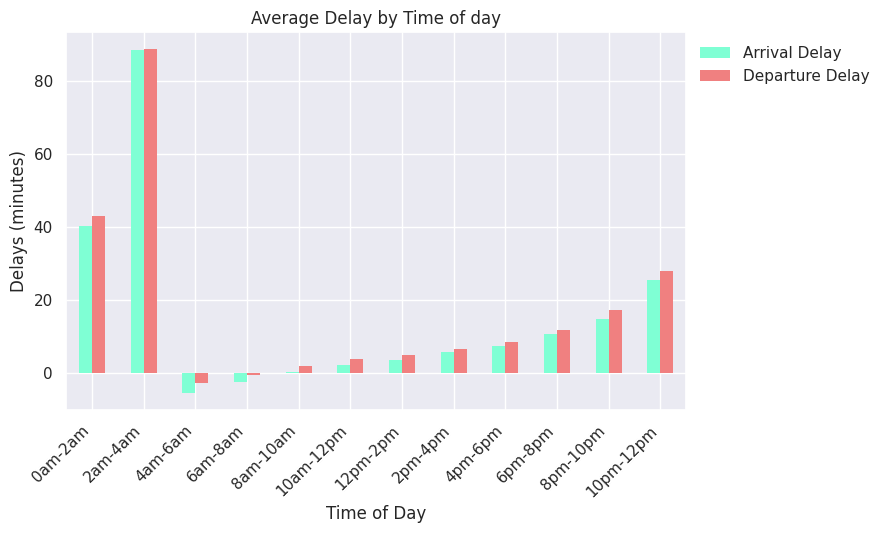

In [95]:
df_time = df.filter(['Date','DayOfWeek','DepTime','ArrTime','ArrDelay','DepDelay'])
time_bins = [i*200 for i in range(13)]
time_labels = ['0am-2am', '2am-4am', '4am-6am', '6am-8am', '8am-10am', '10am-12pm', '12pm-2pm', '2pm-4pm', '4pm-6pm', '6pm-8pm', '8pm-10pm', '10pm-12pm']

df_time['DepTimeRange'] = pd.cut(df_time['DepTime'], bins=time_bins, labels=time_labels)
df_time = df_time.filter(['DepTimeRange','DepDelay','ArrDelay'])
bestdeptime = df_time.groupby('DepTimeRange')['ArrDelay','DepDelay'].mean()

# chart style
sns.set_style("darkgrid")
plt.style.use('seaborn-darkgrid')
# set plot size
sns.set(rc = {'figure.figsize':(8,5)})
plt.rcParams['figure.figsize']=[8,5]
plt.rcParams['figure.dpi']= 100

# Plot time/day delay graph
ax = bestdeptime[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('aquamarine', 'lightcoral'), edgecolor="None")
ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Time of Day')
ax.set_title('Average Delay by Time of day')
ax.legend(labels=['Arrival Delay','Departure Delay'], loc=2, bbox_to_anchor=(1, 1))
ax.set_xticklabels(time_labels, rotation=45, ha='right')

It can be concluded that around 8am-10am would be the best time to fly given the departure and arrival delay is at minimum.

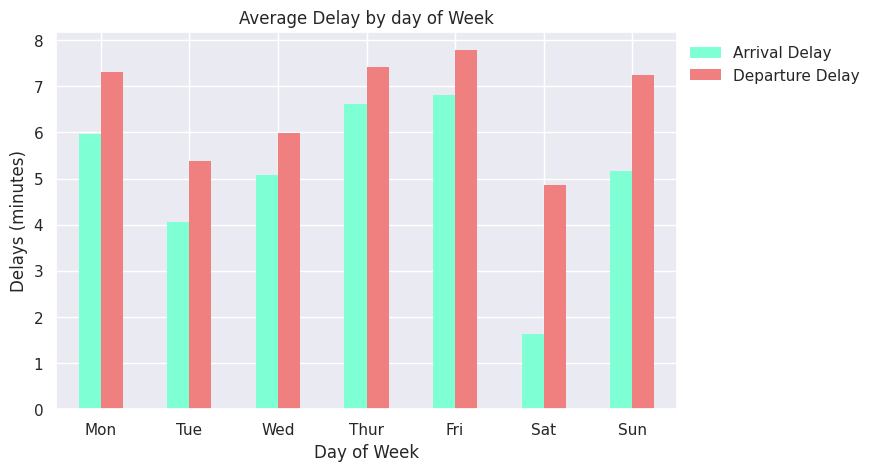

In [96]:
df_week = df.filter(['DayOfWeek','ArrDelay','DepDelay'])

# change weekdays from int to name
week = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thur", 5:"Fri", 6:"Sat", 7:"Sun"}
df_week['DayOfWeek'] = df_week['DayOfWeek'].astype('category').apply(lambda x:week[x])
df_week = df_week.groupby('DayOfWeek')['ArrDelay','DepDelay'].mean()

# Plot day/week delay graph
ax = df_week[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('aquamarine', 'lightcoral'), edgecolor="None")
ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Day of Week')
ax.set_title('Average Delay by day of Week')
ax.legend(labels=['Arrival Delay','Departure Delay'], loc=2, bbox_to_anchor=(1, 1))

It can be concluded that Sunday would be the best day of the week to fly given the departure and arrival delay is at minimum.

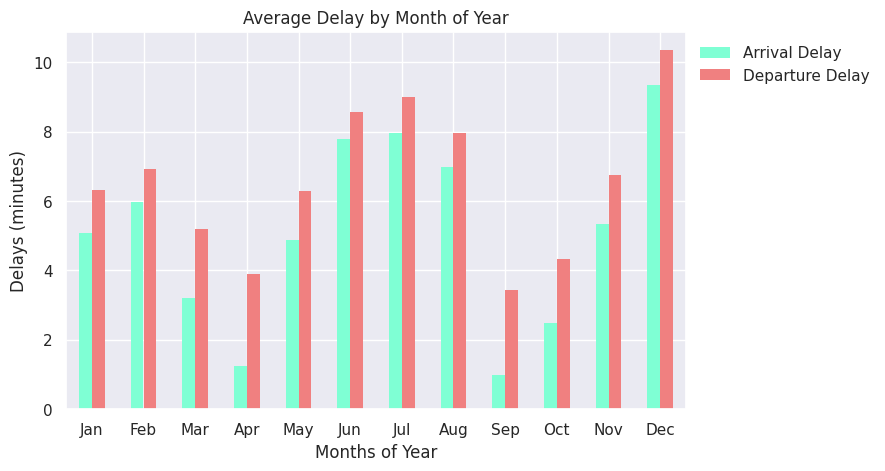

In [97]:
df_month = df[['Date','ArrDelay','DepDelay']].copy()
df_month['month'] = pd.DatetimeIndex(df_month['Date']).month
month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df_month['month'] = df_month['month'].astype('category').apply(lambda x:month[x])
df_month = df_month.groupby('month')['ArrDelay','DepDelay'].mean()

# Plot month/year delay graph
ax = df_month[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('aquamarine', 'lightcoral'), edgecolor="None")
ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Months of Year')
ax.set_title('Average Delay by Month of Year')
ax.legend(labels=['Arrival Delay','Departure Delay'], loc=2, bbox_to_anchor=(1, 1))

It can be concluded that September would be the best month of the year to fly given the departure and arrival delay is at minimum.

## Question 2: How does the number of people flying between different locations change over time? 

Text(0.5, 1.0, 'Average Count by Month of Year')

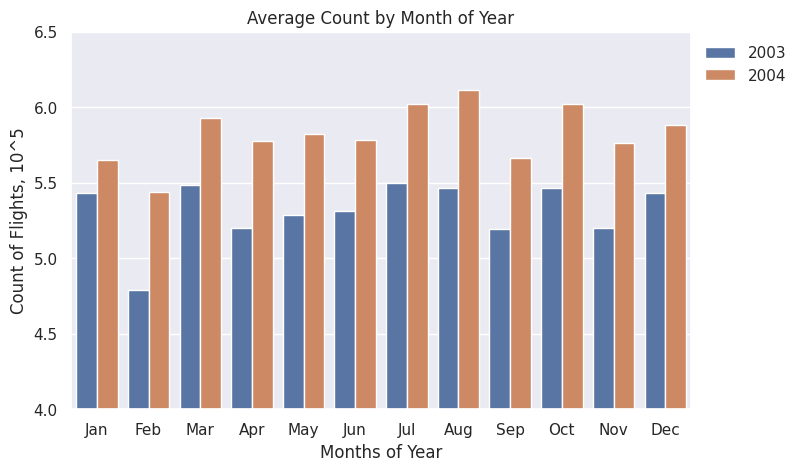

In [98]:
# Group the data by Year and Month
df_count = df.filter(['Date'])
df_count['month'] = pd.DatetimeIndex(df_count['Date']).month
df_count['year'] = pd.DatetimeIndex(df_count['Date']).year

df_count = df_count.groupby(['year', 'month'], as_index = False).size()
month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df_count['month'] = df_count['month'].astype('category').apply(lambda x:month[x])
df_count['size']/=100000
df_count_pivot = df_count.pivot_table(index = 'year', columns = 'month', values = 'size')

# Plot barchat
ax1 = sns.barplot(x='month', y='size', hue='year', data=df_count)
ax1.set(ylim=(4, 6.5))
ax1.legend(loc=2, bbox_to_anchor=(1, 1))
ax1.set_ylabel('Count of Flights, 10^5')
ax1.set_xlabel('Months of Year')
ax1.set_title('Average Count by Month of Year')

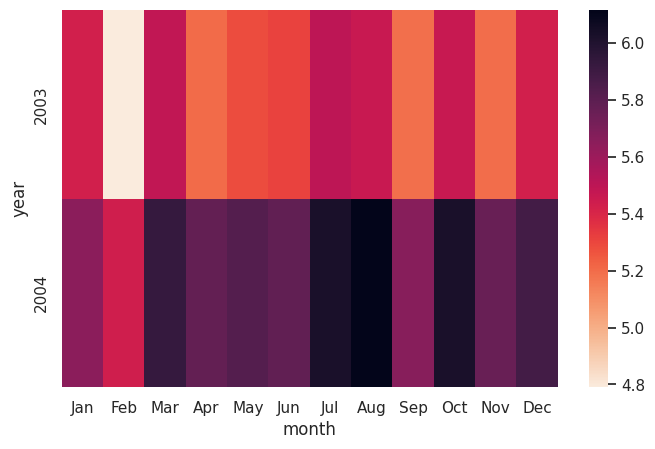

In [99]:
# Plot heatmap
ax2 = sns.heatmap(df_count_pivot, cmap = "rocket_r")

From barchat and heatmap, it can be observed that the number of people taking flights has increased from year 2003 to 2004. Besides, a common similarity where the relatively high number of flights were observed during March, July, August and October.

## Question 3: Can you detect cascading failures as delays in one airport create delays in others?

In [100]:
df_pair = df.groupby(['Origin', 'Dest'], as_index = False).size()
df_pair = df_pair.sort_values(by=['size'], ascending=False)
df_pair

,Origin,Dest,size
2550,LAX,SAN,29588
4090,SAN,LAX,29524
517,BOS,LGA,25063
2607,LGA,BOS,24561
2616,LGA,DCA,24327
...,...,...,...
2576,LBB,OAK,1
1314,DFW,DHN,1
1319,DFW,EVV,1
4141,SAV,AGS,1


Will take the origin-destination pair with maximum number of flights, which is Origin: LAX, Destination: SAN

Text(0.5, 1.0, 'Estimating Flight Delays between LAX and SAN airports during year 2003 and 2004')

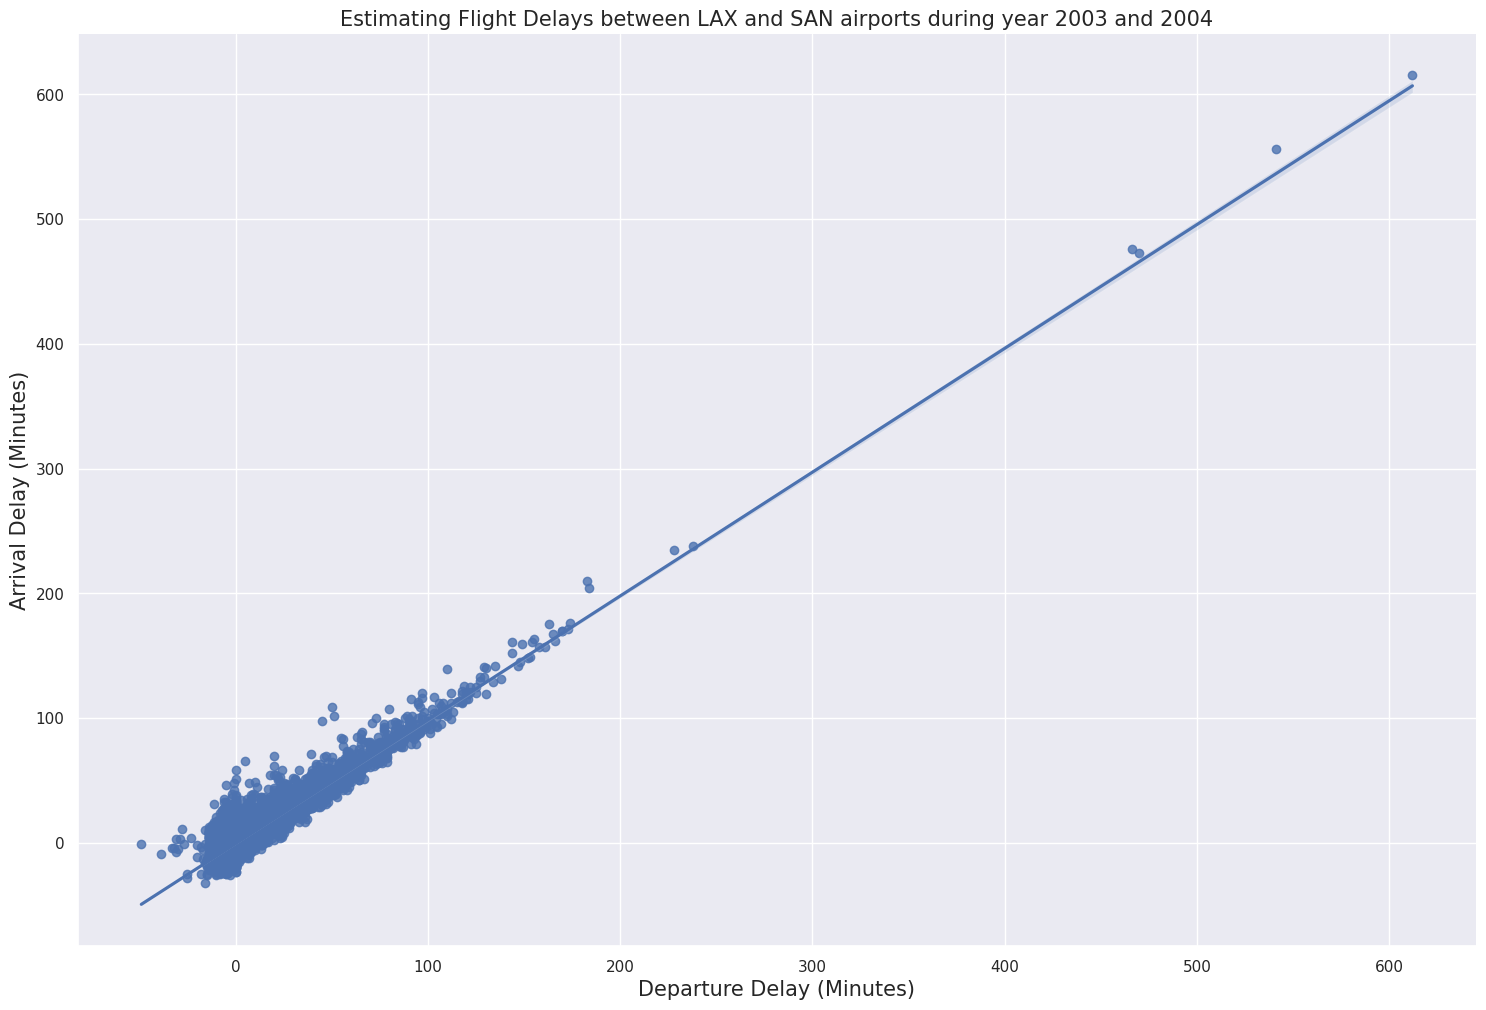

In [101]:
# Select only LAX-SAN pair
df_cascade = df.loc[(df['Origin'] == 'LAX') & (df['Dest'] == 'SAN')]
df_cascade = df_cascade.filter(['DepDelay', 'ArrDelay'])
df_cascade.reset_index(inplace=True, drop=True)

# Plot scatter plot
ax3 = sns.lmplot(x='DepDelay', y='ArrDelay', data=df_cascade, palette='rocket', legend=False, 
           height = 10, aspect = 1.5)
plt.xlabel('Departure Delay (Minutes)', size=15)
plt.ylabel('Arrival Delay (Minutes)', size=15)
plt.title('Estimating Flight Delays between LAX and SAN airports during year 2003 and 2004', size=15)

## Question 4: Use the available variables to construct a model that predicts delays. 

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn import metrics

In [3]:
# read data & concatenate flight of 2 consecutive years -> 2007 & 2008
df = pd.concat([pd.read_csv('2003.csv'),pd.read_csv('2004.csv')], ignore_index=True)
# show header
df.head()
# show total number of samples and no.of attributes
print(df.shape)

(13617810, 29)


In [4]:
# drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [5]:
# # convert month & dayofweek to str
# month = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
# week = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thur", 5:"Fri", 6:"Sat", 7:"Sun"}
# df['Month'] = df['Month'].astype('category').apply(lambda x:month[x])
# df['DayOfWeek'] = df['DayOfWeek'].astype('category').apply(lambda x:week[x])

In [6]:
# remove irrelevant attributes and null
drop_col = ['TailNum', 'TaxiIn', 'TaxiOut', 'CancellationCode']
df.drop(drop_col, axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)

In [7]:
df.dropna(subset=['DepTime', 'ArrTime'], inplace=True)
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
ActualElapsedTime          1
CRSElapsedTime             0
AirTime                    0
ArrDelay                   1
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
Cancelled                  0
Diverted                   0
CarrierDelay         2619862
WeatherDelay         2619862
NASDelay             2619862
SecurityDelay        2619862
LateAircraftDelay    2619862
dtype: int64

In [8]:
df.dropna(subset=['ActualElapsedTime', 'ArrDelay'], inplace=True)
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
ArrDelay                   0
DepDelay                   0
Origin                     0
Dest                       0
Distance                   0
Cancelled                  0
Diverted                   0
CarrierDelay         2619861
WeatherDelay         2619861
NASDelay             2619861
SecurityDelay        2619861
LateAircraftDelay    2619861
dtype: int64

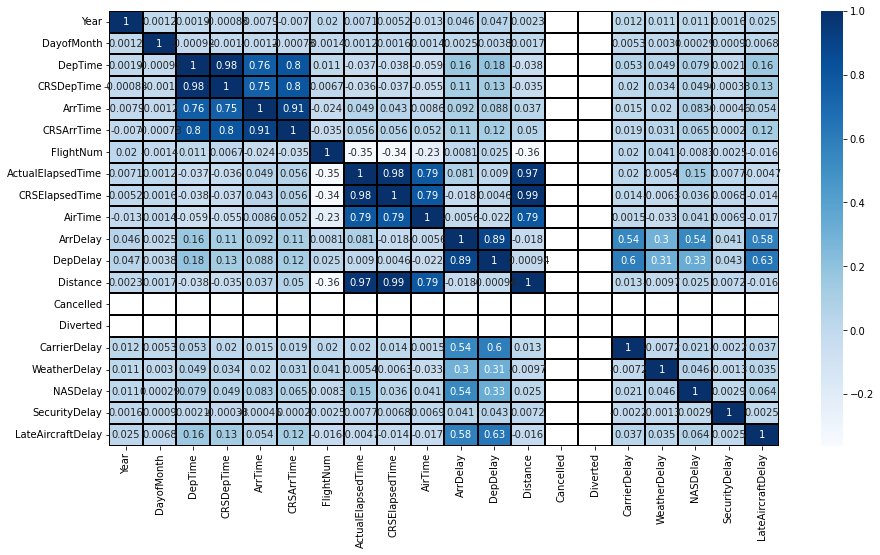

In [9]:
plt.figure(figsize=(15,8))
# Use heatmap to display the correlation values
heatmap = sns.heatmap(df.corr(), cmap="Blues", linewidths=0.1, linecolor='black', annot=True)
plt.show()

The heatmap shows DepTime and ArrTime have strong correlation of 0.89.

In [15]:
# Feature selection
cols_ml = ['CRSDepTime','CRSArrTime','CRSElapsedTime','ActualElapsedTime','Distance','DepDelay','ArrDelay']
dfml = df.filter(cols_ml)

In [16]:
dfml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13363404 entries, 0 to 13617781
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CRSDepTime         int64  
 1   CRSArrTime         int64  
 2   CRSElapsedTime     float64
 3   ActualElapsedTime  float64
 4   Distance           int64  
 5   DepDelay           float64
 6   ArrDelay           float64
dtypes: float64(4), int64(3)
memory usage: 815.6 MB


In [17]:
def delay_status(row):
   return 1 if row['ArrDelay'] > 0 else 0
dfml['ArrStatus'] = dfml.apply(delay_status, axis=1)

In [18]:
dfml.isnull().sum() #check null values

CRSDepTime           0
CRSArrTime           0
CRSElapsedTime       0
ActualElapsedTime    0
Distance             0
DepDelay             0
ArrDelay             0
ArrStatus            0
dtype: int64

In [21]:
# Create X set and y set
x = dfml[cols_ml].copy()
y = dfml[['ArrStatus']].copy() # for logistic regression
y2 = dfml[['ArrDelay']].copy() # for linear regression

# Numeric
numerical_features = cols_ml
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

# Data transformer
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

# Set parameters
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean','median','most_frequent']
    }

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_test, y_train2, y_test2 = train_test_split(x, y2, test_size=0.2, random_state=1)

In [ ]:
# Logistic Regression
pipe_log = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lr', LogisticRegression(max_iter=10000, penalty='none'))])
grid_log = GridSearchCV(pipe_log, param_grid=param_grid)
grid_log.fit(X_train, y_train.values.ravel());
grid_log.score(X_test, y_test)

# calculate additional values
y_pred_log = grid_log.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_log)
print(cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_log))
print("Precision:",metrics.precision_score(y_test, y_pred_log))
print("Recall:",metrics.recall_score(y_test, y_pred_log))

# Linear Regression
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_linear', LinearRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)

grid_lr.fit(X_train, y_train2.values.ravel());
grid_lr.score(X_test, y_test2)

# calculate additional values
y_pred_lr = grid_lr.predict(X_test)
RMSE_lr= np.sqrt(mean_squared_error(y_test2, y_pred_lr))
MSE_lr= mean_squared_error(y_test2, y_pred_lr)
MAE_lr= mean_absolute_error(y_test, y_pred_lr)